In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
import json

# Charger les données
data = pd.read_csv('forensic_data_large.csv')

# Fonction pour détecter les mots-clés SQL
def detect_sql_keywords(query):
    sql_keywords = ["SELECT", "INSERT", "UPDATE", "DELETE", "DROP", "UNION", "ALTER", "CREATE", "EXEC", "XP_"]
    return any(keyword in query.upper() for keyword in sql_keywords)

# Ajouter une colonne pour détecter les mots-clés SQL
data['sql_keywords_detected'] = data['query_parameters'].apply(detect_sql_keywords)

# Supprimer les colonnes inutiles
X = data[['method', 'url', 'query_parameters', 'headers', 'sql_keywords_detected']]
X = pd.get_dummies(X, columns=['method', 'url', 'query_parameters', 'headers'])

# Sauvegarder les colonnes utilisées
with open('columns.json', 'w') as f:
    json.dump(list(X.columns), f)

# Variable cible
y = data['is_attack']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner le modèle
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Sauvegarder le modèle
dump(model, 'forensic.pkl')

# Évaluer le modèle
accuracy = model.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


In [8]:
print(data['is_attack'].value_counts())


is_attack
no     500
yes    500
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5)
print("Validation croisée - Accuracy :", scores.mean())


Validation croisée - Accuracy : 1.0


In [10]:
feature_importances = model.feature_importances_
for name, importance in zip(X.columns, feature_importances):
    print(f"{name}: {importance}")


sql_keywords_detected: 0.1262381557107827
method_GET: 0.001556809591830129
method_POST: 0.0017802709478186333
url_/htmli_get.php: 0.002540385269012711
url_/htmli_post.php: 0.0016571111858080653
url_/htmli_stored.php: 0.0021899806663587323
query_parameters_{"content": "' OR '1'='1"}: 0.0913022667355894
query_parameters_{"content": "'; EXEC xp_cmdshell('dir') --"}: 0.027733835685488362
query_parameters_{"content": "1; DROP TABLE users"}: 0.02924965285234825
query_parameters_{"content": "<a href='javascript:alert(1)'>Click me</a>"}: 0.08379517888097132
query_parameters_{"content": "<div onmouseover='alert("Hacked")'>Hover here</div>"}: 0.1032110415330742
query_parameters_{"content": "<iframe src='http://malicious.com'></iframe>"}: 0.1224384893126598
query_parameters_{"content": "<img src='x' onerror='alert("Injected error")'>"}: 0.07357417954866075
query_parameters_{"content": "<object data='evil.com'></object>"}: 0.1060529204274997
query_parameters_{"content": "<script>alert('XSS')</scri

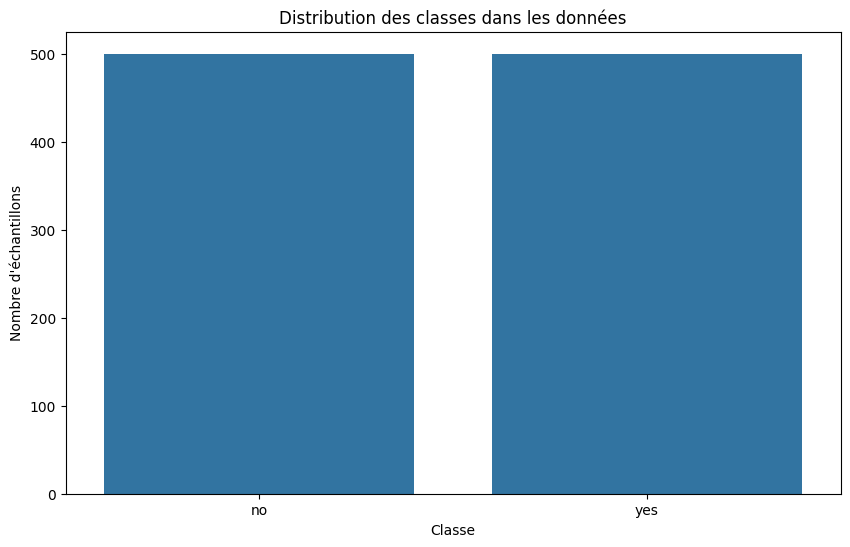

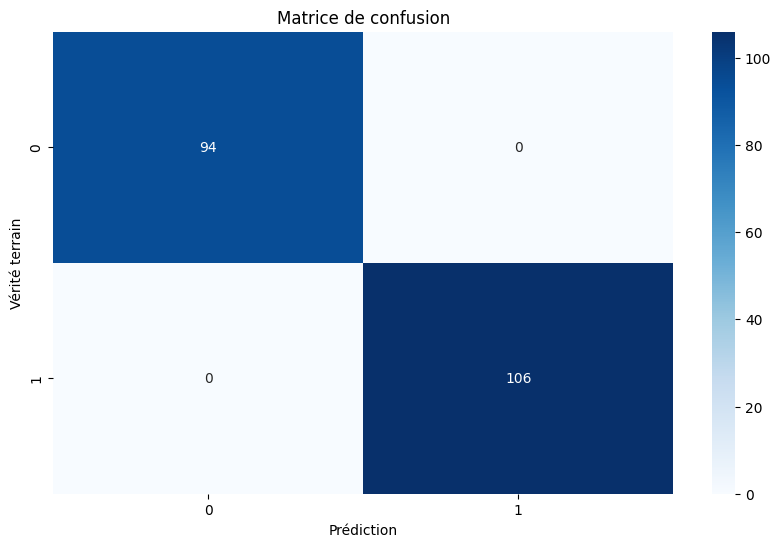

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt

# Distribution des classes dans les données
plt.figure(figsize=(10, 6))
sns.countplot(x='is_attack', data=data)
plt.title('Distribution des classes dans les données')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.show()

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.show()

# Importance des caractéristiques
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

In [12]:
import pandas as pd

# Supposons que 'model' soit votre modèle entraîné et 'X_train' soit votre ensemble de données d'entraînement
feature_importances = model.feature_importances_
features = X_train.columns

# Créer un DataFrame pour les importances des caractéristiques
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Trier les caractéristiques par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher le tableau d'importance des caractéristiques
importance_df

,Feature,Importance
0,sql_keywords_detected,0.126238
11,"query_parameters_{""content"": ""<iframe src='htt...",0.122438
13,"query_parameters_{""content"": ""<object data='ev...",0.106053
10,"query_parameters_{""content"": ""<div onmouseover...",0.103211
14,"query_parameters_{""content"": ""<script>alert('X...",0.093842
...,...,...
60,"query_parameters_{""firstname"": ""Charlie"", ""las...",0.000000
70,"query_parameters_{""firstname"": ""Charlie"", ""las...",0.000000
75,"query_parameters_{""firstname"": ""Charlie"", ""las...",0.000000
76,"query_parameters_{""firstname"": ""Charlie"", ""las...",0.000000


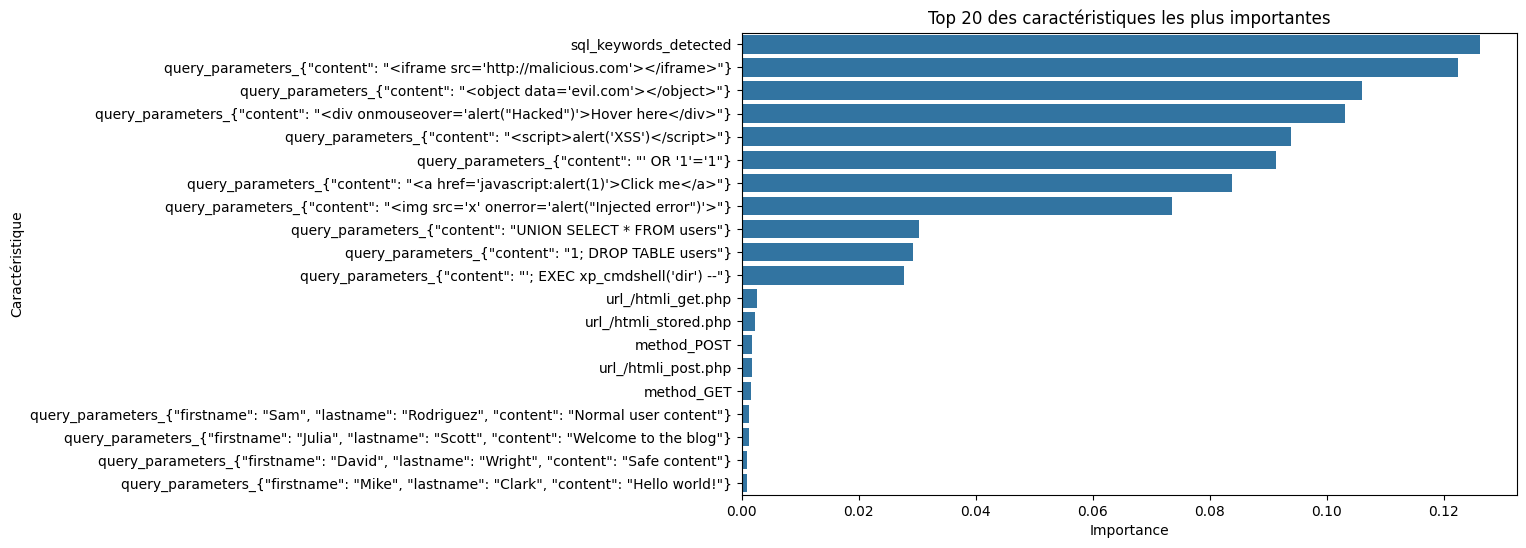

In [13]:
# Sélectionner les 20 caractéristiques les plus importantes
top_20_importance_df = importance_df.head(20)

# Afficher le tableau d'importance des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_20_importance_df)
plt.title('Top 20 des caractéristiques les plus importantes')
plt.xlabel('Importance')
plt.ylabel('Caractéristique')
plt.show()

In [14]:
import joblib

# Sauvegarder le modèle dans un fichier
joblib.dump(model, 'forensic.pkl')

['forensic.pkl']